In [1]:
from flakylib import *
import re
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generation of Synthetic Dataset (Overlapping Blobs on Regular Grid)

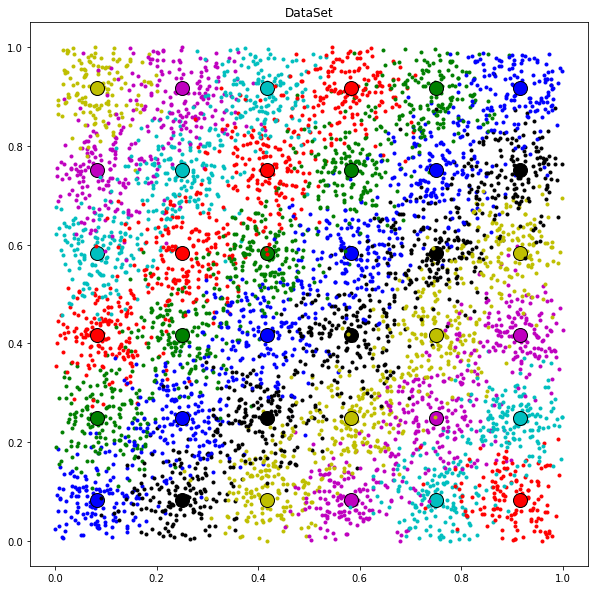

In [2]:
Drawing = True # If n_features > 2 then Drawing = True

grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.06
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing


samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

# Generation of Synthetic Dataset (Random Distributed Blobs)

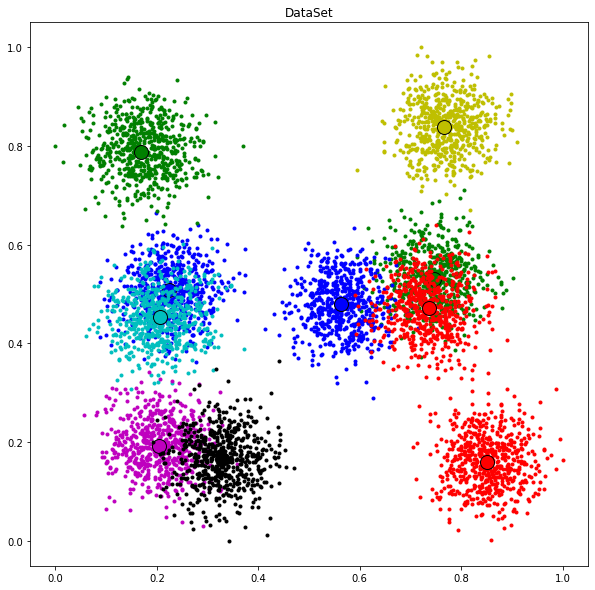

In [57]:
Drawing = True # If n_features > 2 then Drawing = True

grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing
n_cluster = 10

samples, true_centroids, true_sample_membership = generate_dataset1(n_features, n_samples, n_cluster, standard_deviation)


if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   



# Generation of Synthetic Dataset (Random Distributed Samples)

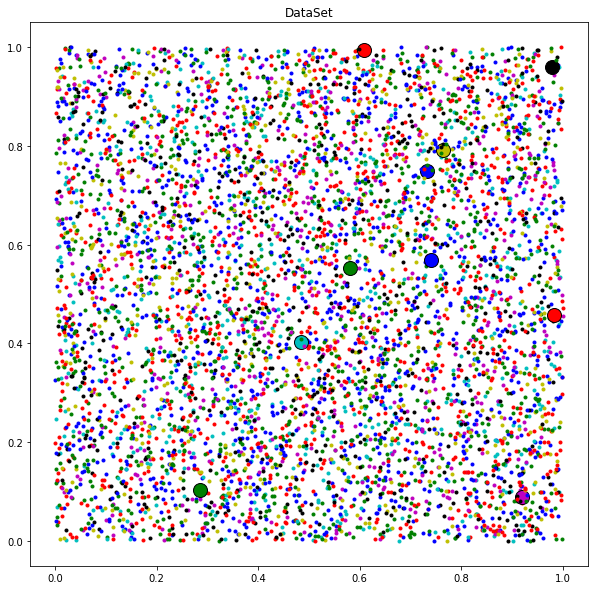

In [58]:
Drawing = True # If n_features > 2 then Drawing = True

n_features = 2
n_samples = 6000
n_clusters = 10
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples = np.random.sample((n_samples,n_features))

true_sample_membership = np.random.randint(n_clusters, size = n_samples)
true_centroids = np.random.sample((n_clusters,n_features))

if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
 

# Initialization by True Centroids

In [3]:
%%time

centroids = np.copy(true_centroids)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 23.46362980350345

CPU times: user 2.24 s, sys: 0 ns, total: 2.24 s
Wall time: 2.23 s


# Initialization by Random Centroids

In [4]:
%%time

centroids = np.random.rand(n_clusters, n_features)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')


Objective 51.2778918231431

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.32 ms


# Initialization by K-Means++

In [5]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
centroids_copy = np.copy(centroids)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 31.45906252573259

CPU times: user 7.49 s, sys: 40 ms, total: 7.53 s
Wall time: 7.48 s


# K-Means initialized by True Centroids

In [6]:
%%time

centroids = np.copy(true_centroids)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 22.543131275735156
Iterations: 19
Clusters: 36

CPU times: user 7.07 s, sys: 24 ms, total: 7.09 s
Wall time: 7.05 s


# K-Means initialized by K-Means++ with sample_objectives as weights

In [68]:
new_sample_weights = 1-normalization(sample_objectives)
center_inds = k_means_pp(samples, new_sample_weights, n_clusters, n_candidates)
centroids = samples[center_inds]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.260429210089878
Iterations: 124
Clusters: 36



# K-Means initialized by Random Centroids

In [7]:
%%time

centroids = np.random.rand(n_clusters, n_features)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.04930725411784
Iterations: 38
Clusters: 36

CPU times: user 84 ms, sys: 8 ms, total: 92 ms
Wall time: 22.2 ms


# K-Means initialized by K-Means++

In [8]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.133667977020743
Iterations: 43
Clusters: 36

CPU times: user 128 ms, sys: 12 ms, total: 140 ms
Wall time: 32.8 ms


# K-Means initialized by K-Means++ (sklearn)

In [9]:
%%time

# MiniBatchKMeans(KMeans) in SKLEARN ????!!!!

km = KMeans(n_clusters=n_clusters, init = 'k-means++', algorithm = 'full', n_init=1, n_jobs=1)
#km = KMeans(n_clusters=n_clusters, init = 'random', n_init=1, n_jobs=1)
km = km.fit(samples)

print('Objective:', -km.score(samples))
print('Iterations:',km.n_iter_)

Objective: 23.56964236529182
Iterations: 61
CPU times: user 1.28 s, sys: 52 ms, total: 1.33 s
Wall time: 269 ms


# H-Means (first-improvement strategy) initialized by True Centroids

In [72]:
%%time

centroids = np.copy(true_centroids)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 22.823831003376753
Iterations: 10
Clusters: 36

CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 79.8 ms


# H-Means (first-improvement strategy) initialized by K-Means++

In [73]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.604613438633066
Iterations: 24
Clusters: 36

CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 166 ms


# H-Means initialized by Random Membership Distribution

In [74]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

random_membership(n_samples, n_clusters, sample_membership)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.88234945264248
Iterations: 26
Clusters: 36

CPU times: user 184 ms, sys: 4 ms, total: 188 ms
Wall time: 187 ms


# K-H-Means initialized by True Centroids

In [75]:
%%time

centroids = np.copy(true_centroids)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001

objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 22.823474129485238
Iterations: 22
Clusters: 36

CPU times: user 84 ms, sys: 8 ms, total: 92 ms
Wall time: 48.6 ms


# K-H-Means initialized by K-Means++

In [76]:
%%time

centroids = np.copy(centroids_copy)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001


objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.616060540904552
Iterations: 43
Clusters: 36

CPU times: user 148 ms, sys: 4 ms, total: 152 ms
Wall time: 82 ms


# Simple Membership Shaking VNS

In [15]:
%%time

max_cpu_time = 10 # seconds
max_iters = 3000 # maximun number of iterations inside VNS

kmax = 3
h_max_iters = 3000
k_max_iters = 3000
h_tol = 0.00000001
k_tol = 0.00000001


#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

#Glogal search

objective, n_iters = Membership_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, h_max_iters, k_tol, h_tol, kmax, max_cpu_time, max_iters, True)

print('')
print('Final objective:', objective)
print('Total number of iterations:', n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 22.554514378797194
Iterations: 60
Clusters: 36

22.554514378797187 1
22.554514378797183 3
22.554253838756058 2
22.554226536292123 3
22.55335189154282 1
22.55330571324107 1
22.553305713241063 3
22.552866058277292 3
22.55286605827729 1
22.552866058277285 1
22.55125442265446 2
22.551254422654456 1
22.551254422654452 1
22.55125442265445 3
22.55125442265445

Final objective: 22.55125442265445
Total number of iterations: 901
Clusters: 36

CPU times: user 16.3 s, sys: 1.2 s, total: 17.5 s
Wall time: 10.1 s


# Solution Visualization

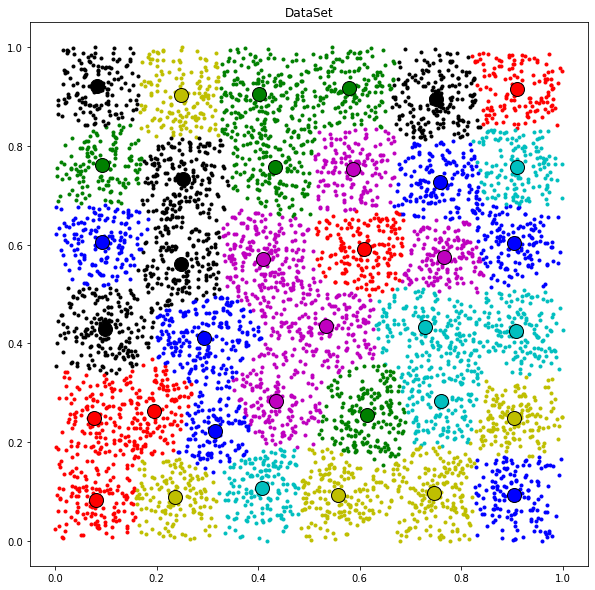

In [11]:
draw_dataset(samples, centroids, sample_membership)

# Local Search by Iteratively New Extra Center Insertion, Searching and Worst Centroid Deletion

In [18]:
%%time

k_max_iters = 600
k_tol=0.000001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, k_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Search

objective, n_iters, n_k_iters = iterative_extra_center_insertion_deletion(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, k_tol, max_iters, tol, max_cpu_time, n_candidates, True)
                                
print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_k_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.193294022278792
Iterations: 56
Clusters: 36

22.981507988337658
22.96393523272627
22.961167241209274
22.89677746207724
22.546777755245024
22.546005931424865
22.543142908577096
22.5394177166836
22.531045688541568
22.529183316244307
22.529183316244307

Objective: 22.529183316244307
Global Iterations: 487
Local Iterations: 26
Clusters: 36

CPU times: user 1min 2s, sys: 5.87 s, total: 1min 7s
Wall time: 10 s


# Solution Visualization

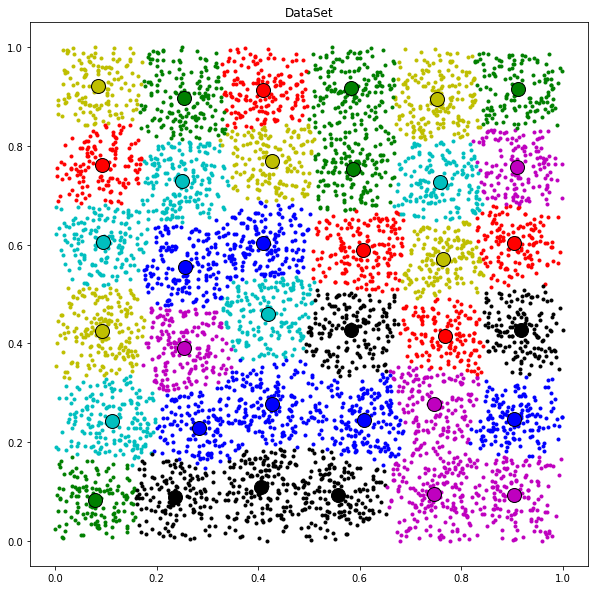

In [13]:
draw_dataset(samples, centroids, sample_membership)

# Simple Center Shaking VNS

In [17]:
%%time

kmax = 5

local_max_iters = 600
local_tol=0.000001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, local_max_iters, local_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Global Search

objective, n_iters, n_local_iters = Center_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, local_max_iters, local_tol, kmax, max_cpu_time, max_iters, n_candidates, True)

print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.122706524382863
Iterations: 72
Clusters: 36

22.955401440585018 1
22.8306638219832 2
22.556187572342996 1
22.555456669866093 1
22.543830955966182 1
22.54192023593244 4
22.532622572349315 1
22.531619169677708 2
22.530881598017597 1
22.53050006573813 1
22.528032172782265 2
22.527044513874138 1
22.526728662514238 1
22.526643557690974 1
22.525441041388927 1
22.525441041388927

Objective: 22.525441041388927
Global Iterations: 721
Local Iterations: 17
Clusters: 36

CPU times: user 1min 5s, sys: 6.24 s, total: 1min 11s
Wall time: 10.1 s


# Solution Visualization

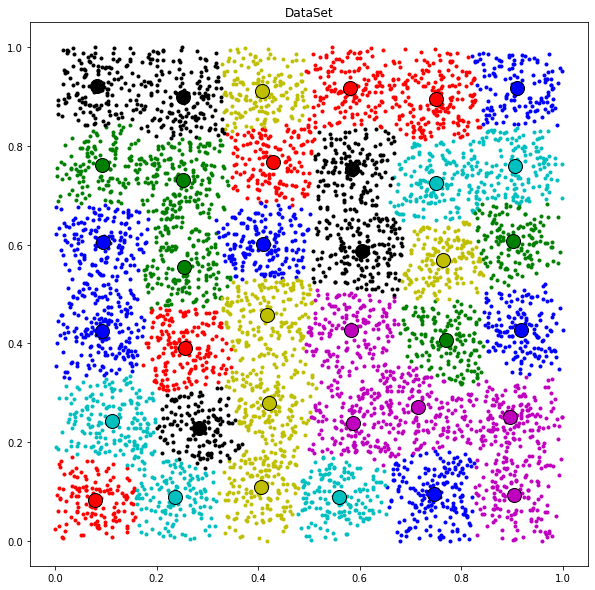

In [19]:
draw_dataset(samples, centroids, sample_membership)

# Sequencing of Different Methods

In [104]:
%%time

printing=True
local_max_iters=300
local_tol=0.00001
n_candidates=3
kmax = 5
max_iters = 3000
max_cpu_time = 3 # seconds


method_sequence = np.array([0, 4, 5, 4, 5, 3])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)
#kmax_sequence = np.full(method_sequence.shape[0],kmax)
kmax_sequence = np.array([5,5,5,5,15,5])

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

objective = method_sequencing(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, np.inf, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, local_max_iters, local_tol, n_candidates, printing)

K-means:
23.2488511044887

Center Shaking VNS:
23.19064654075099 1
23.1806140459445 1
22.810473770340035 2
22.785527433375634 1
22.782300383586694 2
22.781637886408152 4
22.78099956309069 1
22.771232059513046 5
22.767592314648276 2
22.767373192813373 2
22.76481098463509 3
22.76327812774819 2
22.763066551717632 1
22.762644717825903 1
22.762641968569746 1
22.76256623053587 1
22.750430129815737 4
22.75033052274788 2
22.747303771470488 5
22.747299659157605 2
22.747078156654187 1
22.747078156654187

Membership Shaking VNS:
22.746890311001447 1
22.746751563674003 1
22.746729350747263 5
22.74657738849038 1
22.746577388490376 2
22.746577388490373 2
22.74657738849037 4
22.74609602996495 3
22.746096029964946 3
22.74406939279263 4
22.744069392792614 3
22.7437482503111 5
22.743748250311096 1
22.743748250311093 4
22.74374825031109 4
22.74374825031109

Center Shaking VNS:
22.74370033290929 1
22.74370033290929

Membership Shaking VNS:
22.74365710880984 1
22.74365710880983 13
22.743657108809828 6
22.7

# Solution Visualization

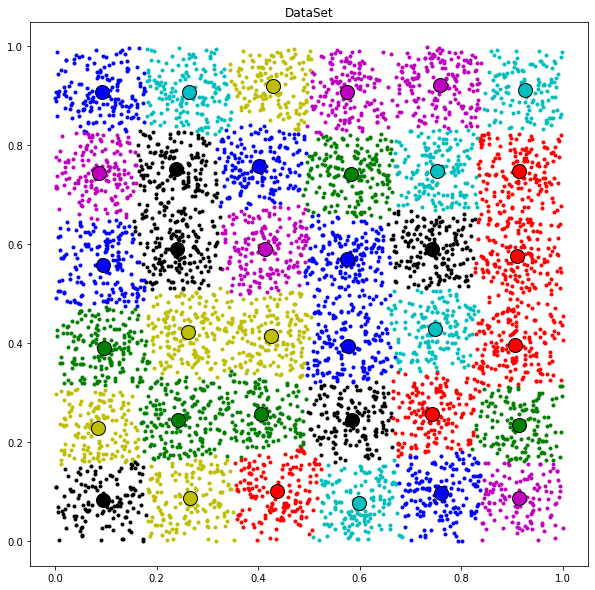

In [105]:
draw_dataset(samples, centroids, sample_membership)

# VNS based Decomposition/Aggregation Minimum Sum-Of-Squares Clustering

In [88]:
%%time

portion_size = 1000
n_portions = 5
init_method = 1
local_max_iters = 3000
local_tol = 0.000000001
max_cpu_time = 3
max_iters = 3000000
n_candidates = 6
aggregation_method = 1
basis_n_init = 3


# method_sequence = np.array([0, 4, 5, 4, 5, 3])
# kmax_sequence = np.array([0,5,5,5,15,0])
# time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
# max_iters_sequence = np.full(method_sequence.shape[0],max_iters)

method_sequence = np.array([4])
kmax_sequence = np.array([5])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)


objective, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = decomposition_aggregation_mssc(samples, sample_weights, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, n_clusters, portion_size, n_portions, init_method, local_max_iters, local_tol, n_candidates, aggregation_method, basis_n_init)



CPU times: user 50.9 s, sys: 5.95 s, total: 56.8 s
Wall time: 9.03 s


In [89]:
objective

22.795233246699517